# Khám phá dữ liệu trên tập dữ liệu mua sắm ở siêu thị

## 0. Chuẩn bị thư viện

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
import sklearn


## 1. Chuẩn bị dữ liệu

In [2]:
retail_data = pd.read_excel("Online Retail.xlsx", engine="openpyxl")
retail_data = retail_data[["InvoiceNo", "StockCode", "Description", "Quantity", "InvoiceDate", "UnitPrice", "CustomerID", "Country"]]


In [3]:
display(retail_data.head())


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## 2. Khám phá dữ liệu ban đầu

Trước hết, chúng ta cần kiểm tra các thông tin cơ bản nhất

In [4]:
print("Số dòng:", retail_data.shape[0])
print("Số cột:", retail_data.shape[1])
print("\nKiểu dữ liệu từng cột:")
print(retail_data.dtypes)


Số dòng: 541909
Số cột: 8

Kiểu dữ liệu từng cột:
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object


Tiếp đến, chúng ta cần kiểm tra các dữ liệu bị thiếu và dữ liệu trùng lặp

In [5]:
missing_count = retail_data.isnull().sum()
missing_percent = (missing_count / len(retail_data)) * 100

missing_summary = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percent (%)': missing_percent.round(2)
})

display(missing_summary)


,Missing Count,Missing Percent (%)
InvoiceNo,0,0.00
StockCode,0,0.00
Description,1454,0.27
Quantity,0,0.00
InvoiceDate,0,0.00
UnitPrice,0,0.00
CustomerID,135080,24.93
Country,0,0.00


In [6]:
duplicate_count = retail_data.duplicated().sum()
print(f"Số dòng dữ liệu trùng lặp: {duplicate_count}")

if duplicate_count > 0:
    print("Các dòng trùng lặp (hiển thị 5 dòng đầu):")
    display(retail_data[retail_data.duplicated()].head())
else:
    print("Không có dữ liệu trùng lặp trong retail_data.")


Số dòng dữ liệu trùng lặp: 5268
Các dòng trùng lặp (hiển thị 5 dòng đầu):


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-12-01 11:49:00,2.95,17920.0,United Kingdom


Cuối cùng, chúng ta sẽ thực hiện việc thống kê mô tả, ở đây chúng ta sẽ chỉ thống kê các số liệu có thể tính được: 

In [7]:
# Tính toán các thống kê mô tả cho Quantity và UnitPrice
columns = ['Quantity', 'UnitPrice']
stats_summary = {}

for col in columns:
    data = retail_data[col].dropna().values

    mean = np.mean(data)
    median = np.median(data)
    mode = stats.mode(data, keepdims=True)[0][0]
    variance = np.var(data, ddof=1)
    std_dev = np.std(data, ddof=1)
    data_range = np.ptp(data)
    percentile_25 = np.percentile(data, 25)
    percentile_50 = np.percentile(data, 50)
    percentile_75 = np.percentile(data, 75)
    iqr = stats.iqr(data)

    stats_summary[col] = {
        'mean': mean,
        'median': median,
        'mode': mode,
        'variance': variance,
        'std_dev': std_dev,
        'range': data_range,
        'percentile_25': percentile_25,
        'percentile_50': percentile_50,
        'percentile_75': percentile_75,
        'iqr': iqr
    }

pd.DataFrame(stats_summary)


,Quantity,UnitPrice
mean,9.552250,4.611114
median,3.000000,2.080000
mode,1.000000,1.250000
variance,47559.391409,9362.469164
std_dev,218.081158,96.759853
range,161990.000000,50032.060000
percentile_25,1.000000,1.250000
percentile_50,3.000000,2.080000
percentile_75,10.000000,4.130000
iqr,9.000000,2.880000


## 3. Tiền xử lý dữ liệu

Đầu tiên, chúng ta sẽ xử lý dữ liệu bị thiếu và dữ liệu trùng lặp

In [8]:
# Xử lý dữ liệu bị thiếu: loại bỏ các dòng có giá trị thiếu
retail_data_cleaned = retail_data.dropna()
print(f"Đã xử lý dữ liệu bị thiếu. Số dòng dữ liệu sau khi loại bỏ: {retail_data_cleaned.shape[0]}")

# Xử lý dữ liệu trùng lặp: loại bỏ các dòng bị trùng lặp
retail_data_cleaned = retail_data_cleaned.drop_duplicates()
print(f"Đã xử lý dữ liệu trùng lặp. Số dòng dữ liệu sau khi loại bỏ: {retail_data_cleaned.shape[0]}")


Đã xử lý dữ liệu bị thiếu. Số dòng dữ liệu sau khi loại bỏ: 406829
Đã xử lý dữ liệu trùng lặp. Số dòng dữ liệu sau khi loại bỏ: 401604


Sau đó, chúng ta sẽ xử lý dữ liệu bất hợp lý. Ở đây, chúng ta sẽ chỉ tập trung vào 2 thuộc tính: Quantity và UnitPrice, là thuộc tính có thể tính toán được. 
* Loại bỏ Quantity ≤ 0 (trả hàng).
* Loại bỏ UnitPrice ≤ 0 (lỗi nhập liệu).

In [ ]:
# Loại bỏ các dòng có Quantity ≤ 0 hoặc UnitPrice ≤ 0
retail_data_cleaned = retail_data_cleaned[(retail_data_cleaned['Quantity'] > 0) & (retail_data_cleaned['UnitPrice'] > 0)]
print(f"Số dòng dữ liệu sau khi loại bỏ bất thường: {retail_data_cleaned.shape[0]}")


Số dòng dữ liệu sau khi loại bỏ bất thường: 392692


Cuối cùng, để dễ dàng cho việc phân tích, chúng ta sẽ tạo 1 số biến mới từ các biến đơn có sẵn

In [ ]:
# Tạo biến TotalPrice
retail_data_cleaned['TotalPrice'] = retail_data_cleaned['Quantity'] * retail_data_cleaned['UnitPrice']

# Tạo các biến thời gian từ InvoiceDate
retail_data_cleaned['Month'] = retail_data_cleaned['InvoiceDate'].dt.month
retail_data_cleaned['Day'] = retail_data_cleaned['InvoiceDate'].dt.day
retail_data_cleaned['Hour'] = retail_data_cleaned['InvoiceDate'].dt.hour


## 4. Phân tích tổng quan

Trước hết, chúng ta sẽ tính doanh thu tổng thể, doanh thu theo từng quốc gia và số lượng đơn theo tháng:

In [ ]:
print("Tổng doanh thu:", retail_data_cleaned['TotalPrice'].sum())


Tổng doanh thu: 8887208.894


<Axes: title={'center': 'Doanh thu theo tháng'}, xlabel='Month'>

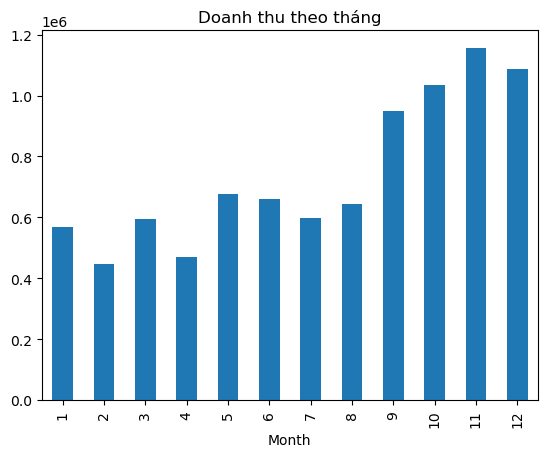

In [ ]:
month_revenue = retail_data_cleaned.groupby('Month')['TotalPrice'].sum()
month_revenue.plot(kind='bar', title='Doanh thu theo tháng')


<Axes: title={'center': 'Số lượng đơn hàng theo tháng'}, xlabel='Month'>

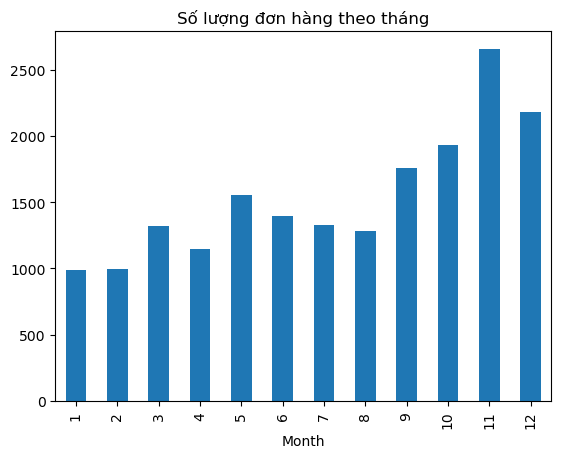

In [ ]:
monthly_orders = retail_data_cleaned.groupby('Month')['InvoiceNo'].nunique()
monthly_orders.plot(kind='bar', title='Số lượng đơn hàng theo tháng')


### Quan sát hai biểu đồ trên, ta thấy:

- **Doanh thu theo tháng**: Biểu đồ doanh thu theo tháng cho thấy doanh thu có xu hướng tăng mạnh vào các tháng cuối năm, đặc biệt là tháng 11 và 12. Điều này có thể liên quan đến các dịp lễ hội, mua sắm cuối năm, khi nhu cầu tiêu dùng tăng cao. Các tháng giữa năm có doanh thu thấp hơn, phản ánh chu kỳ kinh doanh theo mùa của siêu thị.

- **Số lượng đơn hàng theo tháng**: Số lượng đơn hàng cũng tăng dần từ đầu năm đến cuối năm, với đỉnh cao vào tháng 11 và 12. Điều này cho thấy không chỉ giá trị đơn hàng mà cả số lượng giao dịch đều tăng vào các tháng cao điểm, phù hợp với xu hướng tiêu dùng trong các dịp lễ hội và khuyến mãi. Các tháng đầu năm và giữa năm có số lượng đơn hàng thấp hơn, phản ánh sự biến động theo mùa trong hoạt động bán lẻ.

## 5. Phân tích sản phẩm

Tiếp theo, chúng ta sẽ phân tích độ bán chạy của sản phẩm:

<Axes: title={'center': 'Top 10 sản phẩm bán chạy'}, ylabel='Description'>

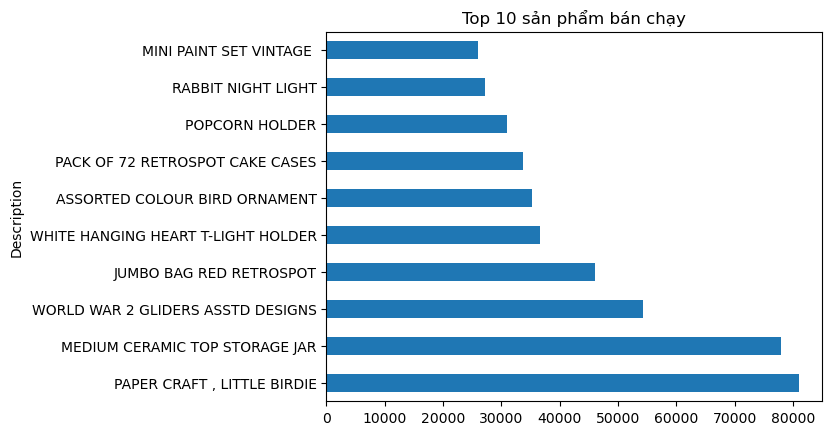

In [ ]:
top_products = retail_data_cleaned.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
top_products.plot(kind='barh', title='Top 10 sản phẩm bán chạy')


<Axes: title={'center': 'Top 10 sản phẩm có doanh thu cao nhất'}, ylabel='Description'>

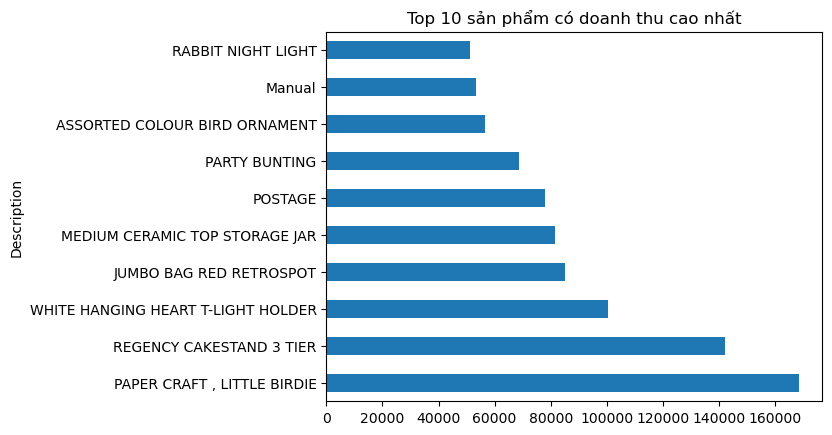

In [ ]:
top_revenue_products = retail_data_cleaned.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)
top_revenue_products.plot(kind='barh', title='Top 10 sản phẩm có doanh thu cao nhất')


Nhìn vào đây, ta nhận thấy sự khác biệt:

Các sản phẩm bán chạy nhất (theo số lượng) chủ yếu là các mặt hàng giá thấp, phổ biến, dễ tiêu thụ như đồ trang trí, túi, hộp, vật dụng nhỏ. Trong khi đó, các sản phẩm có doanh thu cao nhất lại bao gồm cả những mặt hàng giá trị lớn (ví dụ: kệ bánh, sản phẩm đặc biệt, phí vận chuyển). Điều này cho thấy:

- Một sản phẩm có thể bán rất nhiều nhưng nếu giá thấp thì tổng doanh thu chưa chắc cao.
- Ngược lại, sản phẩm giá cao hoặc có giá trị đặc biệt (như kệ bánh, phí vận chuyển) dù số lượng bán ra không lớn nhưng vẫn đóng góp doanh thu lớn.

Lý do của sự khác biệt này là do cơ cấu giá bán và nhu cầu tiêu dùng: sản phẩm phổ thông, giá rẻ thường được mua với số lượng lớn, còn sản phẩm giá trị cao hoặc đặc biệt thường được mua ít nhưng mang lại doanh thu lớn. Kết luận: để tối ưu doanh thu, siêu thị cần cân bằng giữa việc thúc đẩy các sản phẩm bán chạy và phát triển các sản phẩm giá trị cao, đồng thời chú ý đến các dịch vụ đi kèm như phí vận chuyển.

## 6. Phân tích khách hàng

Tiếp đến, ta sẽ phân tích tệp khách hàng mua sắm:

<Axes: title={'center': 'Top 10 khách hàng chi tiêu nhiều nhất'}, xlabel='CustomerID'>

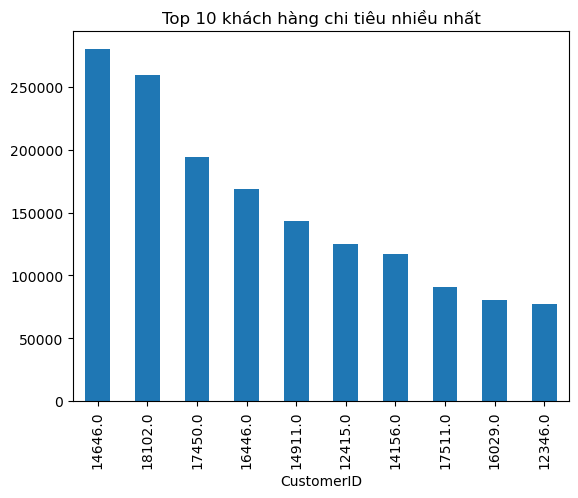

In [ ]:
top_customers = retail_data_cleaned.groupby('CustomerID')['TotalPrice'].sum().sort_values(ascending=False).head(10)
top_customers.plot(kind='bar', title='Top 10 khách hàng chi tiêu nhiều nhất')


In [ ]:
avg_order_value = retail_data_cleaned.groupby('InvoiceNo')['TotalPrice'].sum().mean()
print("Giá trị trung bình mỗi đơn hàng:", avg_order_value)


Giá trị trung bình mỗi đơn hàng: 479.56016047917126


## 7. Phân tích nâng cao

Text(0.5, 1.0, 'Ma trận tương quan')

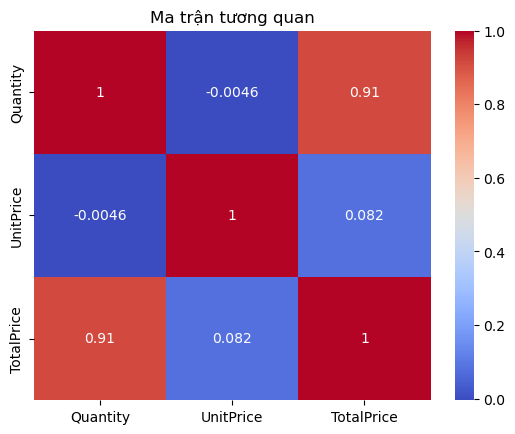

In [ ]:
corr = retail_data_cleaned[['Quantity', 'UnitPrice', 'TotalPrice']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Ma trận tương quan")


### Nhận xét về ma trận tương quan

Biểu đồ ma trận tương quan cho thấy:

- **Quantity và TotalPrice** có tương quan rất mạnh (hệ số ~0.91), điều này hợp lý vì TotalPrice được tính trực tiếp từ Quantity và UnitPrice.
- **UnitPrice và TotalPrice** có tương quan yếu (hệ số ~0.08), cho thấy giá bán đơn vị không ảnh hưởng nhiều đến tổng doanh thu của từng dòng dữ liệu, chủ yếu do số lượng bán ra quyết định.
- **Quantity và UnitPrice** gần như không có tương quan (hệ số ~-0.005), tức là số lượng bán ra của một sản phẩm không phụ thuộc vào giá bán đơn vị.

Như vậy, doanh thu chủ yếu bị chi phối bởi số lượng sản phẩm bán ra, còn giá bán đơn vị chỉ đóng vai trò nhỏ trong từng giao dịch.

## 8. Xử lý ngoại lai

Qua các phân tích trêm, chúng ta nhận thấy bộ đữ liệu còn có nhiều giá trị bất hợp lý so với các số liệu đã thống kê, nên chúng ta sẽ xử lý chúng
* Đầu tiên, chúng ta sẽ đi tìm các giá trị Outliers:

In [ ]:
# Phát hiện outliers cho các cột Quantity và UnitPrice bằng phương pháp IQR
outlier_indices = {}
for col in ['Quantity', 'UnitPrice']:
    Q1 = retail_data_cleaned[col].quantile(0.25)
    Q3 = retail_data_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = retail_data_cleaned[(retail_data_cleaned[col] < lower_bound) | (retail_data_cleaned[col] > upper_bound)]
    outlier_indices[col] = outliers.index

    print(f"Số lượng outliers ở cột {col}: {len(outliers)}")

# Hiển thị một số dòng dữ liệu bị coi là outlier
display(retail_data_cleaned.loc[outlier_indices['Quantity']].head())
display(retail_data_cleaned.loc[outlier_indices['UnitPrice']].head())


Số lượng outliers ở cột Quantity: 25616
Số lượng outliers ở cột UnitPrice: 34112


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Month,Day,Hour
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom,54.08,12,1,8
31,536370,10002,INFLATABLE POLITICAL GLOBE,48,2010-12-01 08:45:00,0.85,12583.0,France,40.80,12,1,8
44,536370,22492,MINI PAINT SET VINTAGE,36,2010-12-01 08:45:00,0.65,12583.0,France,23.40,12,1,8
46,536371,22086,PAPER CHAIN KIT 50'S CHRISTMAS,80,2010-12-01 09:00:00,2.55,13748.0,United Kingdom,204.00,12,1,9
65,536374,21258,VICTORIAN SEWING BOX LARGE,32,2010-12-01 09:09:00,10.95,15100.0,United Kingdom,350.40,12,1,9


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Month,Day,Hour
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,15.3,12,1,8
16,536367,22622,BOX OF VINTAGE ALPHABET BLOCKS,2,2010-12-01 08:34:00,9.95,13047.0,United Kingdom,19.9,12,1,8
19,536367,21777,RECIPE BOX WITH METAL HEART,4,2010-12-01 08:34:00,7.95,13047.0,United Kingdom,31.8,12,1,8
20,536367,48187,DOORMAT NEW ENGLAND,4,2010-12-01 08:34:00,7.95,13047.0,United Kingdom,31.8,12,1,8
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.00,12583.0,France,54.0,12,1,8


* Sau đó chúng ta sẽ xử lý chúng

In [ ]:
# Loại bỏ các dòng outlier khỏi retail_data_cleaned dựa trên chỉ số đã xác định
all_outlier_indices = outlier_indices['Quantity'].union(outlier_indices['UnitPrice'])
valid_outlier_indices = all_outlier_indices.intersection(retail_data_cleaned.index)
retail_data_cleaned = retail_data_cleaned.drop(index=valid_outlier_indices)

print(f"Số dòng dữ liệu sau khi loại bỏ outliers: {retail_data_cleaned.shape[0]}")


Số dòng dữ liệu sau khi loại bỏ outliers: 333234


* Cuối cùng chúng ta sẽ kiểm tra lại:

In [ ]:
# Kiểm tra lại thông tin cơ bản của retail_data_cleaned sau khi loại bỏ outliers
print("Số dòng:", retail_data_cleaned.shape[0])
print("Số cột:", retail_data_cleaned.shape[1])
print("\nKiểu dữ liệu từng cột:")
print(retail_data_cleaned.dtypes)
print("\nKiểm tra dữ liệu bị thiếu:")
print(retail_data_cleaned.isnull().sum())
print("\nThống kê mô tả các cột Quantity và UnitPrice:")
display(retail_data_cleaned[['Quantity', 'UnitPrice']].describe())


Số dòng: 333234
Số cột: 12

Kiểu dữ liệu từng cột:
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
TotalPrice            float64
Month                   int32
Day                     int32
Hour                    int32
dtype: object

Kiểm tra dữ liệu bị thiếu:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalPrice     0
Month          0
Day            0
Hour           0
dtype: int64

Thống kê mô tả các cột Quantity và UnitPrice:


,Quantity,UnitPrice
count,333234.000000,333234.000000
mean,7.550682,2.194218
std,6.777237,1.546015
min,1.000000,0.001000
25%,2.000000,1.250000
50%,6.000000,1.650000
75%,12.000000,2.950000
max,27.000000,7.500000


## Kết thúc